In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



In [120]:
cancer_df = pd.read_csv(r'C:\Users\jaraneses\OneDrive - 2X LLC\Codes\Portfolio Projects_storage\Day 36 - Cancer Prediction using KMeans and PCA\leukemia_cancer_cell.tsv', sep = '\t')
df = cancer_df.copy()

In [121]:
df.head()

,Study ID,Patient ID,Sample ID,Age at Diagnosis,Age At Specimen Acquisition,FLT3-ITD Allelic Ratio,ASXL1,Cancer Type,Cancer Type Detailed,Cause Of Death,...,Specific Diagnosis At Inclusion,Specimen Groups,Specimen Type,Surface Antigens Immunohistochemical Stains,"Time Of Sample Collection, Relative To Inclusion",TMB (nonsynonymous),TP53 Pathway,Treatment Type Induction,Used In Manuscript,Variant Summary
0,aml_ohsu_2022,aml_ohsu_2022_2000,aml_ohsu_2022_2000_BA2123,65.0,65.0,0.0,NaN,Leukemia,Acute Myeloid Leukemia,Dead-Treatment,...,AML with mutated NPM1,Initial Acute Leukemia Diagnosis,Bone Marrow Aspirate,"CD2(-), CD7(-), CD11b(-), CD13(+), CD14(-), CD...",0,0.900000,NaN,NaN,Yes,DNMT3A (W297*; MAF 44%)|FLT3-D835 (D835Y; MAF ...
1,aml_ohsu_2022,aml_ohsu_2022_2001,aml_ohsu_2022_2001_BA2702,68.0,68.0,0.0,NaN,Leukemia,Acute Myeloid Leukemia,Dead-Disease,...,AML with myelodysplasia-related changes,Post-Chemotherapy|Residual Disease,Bone Marrow Aspirate,NaN,34,1.033333,NaN,NaN,Yes,NaN
2,aml_ohsu_2022,aml_ohsu_2022_2003,aml_ohsu_2022_2003_BA2499,71.0,71.0,0.0,NaN,Leukemia,Acute Myeloid Leukemia,Dead-Disease,...,AML with myelodysplasia-related changes,Post-Chemotherapy|Initial Acute Leukemia Diagn...,Peripheral Blood,NaN,0,0.966667,NaN,NaN,Yes,NaN
3,aml_ohsu_2022,aml_ohsu_2022_2004,aml_ohsu_2022_2004_BA2846,75.0,75.0,0.0,NaN,Leukemia,Acute Myeloid Leukemia,Dead-Disease,...,Therapy-related myeloid neoplasms,Initial Acute Leukemia Diagnosis|Post-Chemothe...,Bone Marrow Aspirate,"CD33, dim CD38, variable CD56, CD58, dim CD64,...",0,0.500000,NaN,NaN,Yes,IDH2 (p.R140Q; MAF 47%)|NPM1 (p.W288fs*12 (4 n...
4,aml_ohsu_2022,aml_ohsu_2022_2005,aml_ohsu_2022_2005_BA2802,52.0,53.0,0.0,NaN,Leukemia,Acute Leukemias of Ambiguous Lineage,Dead-Disease,...,"Mixed phenotype acute leukaemia, T/myeloid, NOS",Post-Transplant|Post-Chemotherapy|Residual Dis...,Peripheral Blood,"partial CD7, CD13, CD33, CD34, partial CD56, C...",234,0.066667,TP53 (p.V216M; 66.9%),Standard Chemotherapy,No,NaN


In [122]:
df.info()

# get columns that are relevant, complete and can be encoded

numeric_cols = [
    "Age at Diagnosis",
    "FLT3-ITD Allelic Ratio",
    "Mutation Count",
    "TMB (nonsynonymous)",
    "Overall Survival (Months)",
    "Most Recent Treatment Duration",
    "Response Duration To Induction"
    ]

cat_cols = [
    "Cancer Type",
    "ELN2017",
    "Sex",
    "Response To Induction",
    "Prior MDS",
    "Prior MPN",
    "Relapsed",
    "De Novo"
]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 68 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Study ID                                          942 non-null    object 
 1   Patient ID                                        942 non-null    object 
 2   Sample ID                                         942 non-null    object 
 3   Age at Diagnosis                                  916 non-null    float64
 4   Age At Specimen Acquisition                       926 non-null    float64
 5   FLT3-ITD Allelic Ratio                            864 non-null    float64
 6   ASXL1                                             100 non-null    object 
 7   Cancer Type                                       942 non-null    object 
 8   Cancer Type Detailed                              942 non-null    object 
 9   Cause Of Death       

In [123]:
df = df[numeric_cols + cat_cols]

In [124]:
df.isnull().sum()

Age at Diagnosis                   26
FLT3-ITD Allelic Ratio             78
Mutation Count                     64
TMB (nonsynonymous)                39
Overall Survival (Months)           0
Most Recent Treatment Duration     79
Response Duration To Induction    191
Cancer Type                         0
ELN2017                             0
Sex                                 1
Response To Induction             195
Prior MDS                           0
Prior MPN                           0
Relapsed                            0
De Novo                             0
dtype: int64

In [125]:
df.describe()
# will use median to fill data for the missing values

,Age at Diagnosis,FLT3-ITD Allelic Ratio,Mutation Count,TMB (nonsynonymous),Overall Survival (Months),Most Recent Treatment Duration,Response Duration To Induction
count,916.000000,864.000000,878.000000,903.000000,942.000000,863.000000,751.000000
mean,57.213974,0.456668,8.834852,0.428276,20.758991,38.156431,30.127830
std,17.254826,2.167286,7.946447,0.441425,23.764644,118.536052,200.091185
min,0.000000,0.000000,1.000000,0.000000,-0.032877,-1.000000,-1.000000
25%,47.000000,0.000000,4.000000,0.133333,4.536986,-1.000000,-1.000000
50%,61.000000,0.000000,6.000000,0.266667,11.852055,0.000000,6.000000
75%,70.000000,0.000000,12.000000,0.633333,28.380822,28.000000,7.000000
max,88.000000,32.333333,71.000000,4.233333,177.435616,2197.000000,4626.000000


In [126]:
for col in numeric_cols:
    df.loc[:, col] = df[col].fillna(df[col].median())

df[numeric_cols].isnull().sum()

Age at Diagnosis                  0
FLT3-ITD Allelic Ratio            0
Mutation Count                    0
TMB (nonsynonymous)               0
Overall Survival (Months)         0
Most Recent Treatment Duration    0
Response Duration To Induction    0
dtype: int64

In [127]:
for col in cat_cols:
    df.loc[:, col] = df[col].fillna(df[col].mode()[0])

df[cat_cols].isnull().sum()

Cancer Type              0
ELN2017                  0
Sex                      0
Response To Induction    0
Prior MDS                0
Prior MPN                0
Relapsed                 0
De Novo                  0
dtype: int64

In [128]:
df[df.duplicated()]

,Age at Diagnosis,FLT3-ITD Allelic Ratio,Mutation Count,TMB (nonsynonymous),Overall Survival (Months),Most Recent Treatment Duration,Response Duration To Induction,Cancer Type,ELN2017,Sex,Response To Induction,Prior MDS,Prior MPN,Relapsed,De Novo
223,71.0,0.0,1.0,0.033333,23.638356,9.0,6.0,Leukemia,Intermediate,Female,Complete Response,No,No,FALSE,TRUE
514,62.0,0.0,5.0,0.266667,9.238356,-1.0,6.0,Leukemia,NonInitial,Male,Complete Response,No,No,FALSE,FALSE
843,61.0,0.0,6.0,0.000000,0.000000,0.0,6.0,Leukemia,NonInitial,Female,Complete Response,No,No,unknown,unknown
887,61.0,0.0,2.0,0.100000,0.000000,0.0,6.0,Leukemia,NonInitial,Male,Complete Response,No,No,unknown,unknown


In [129]:
df = df[~df.duplicated()]

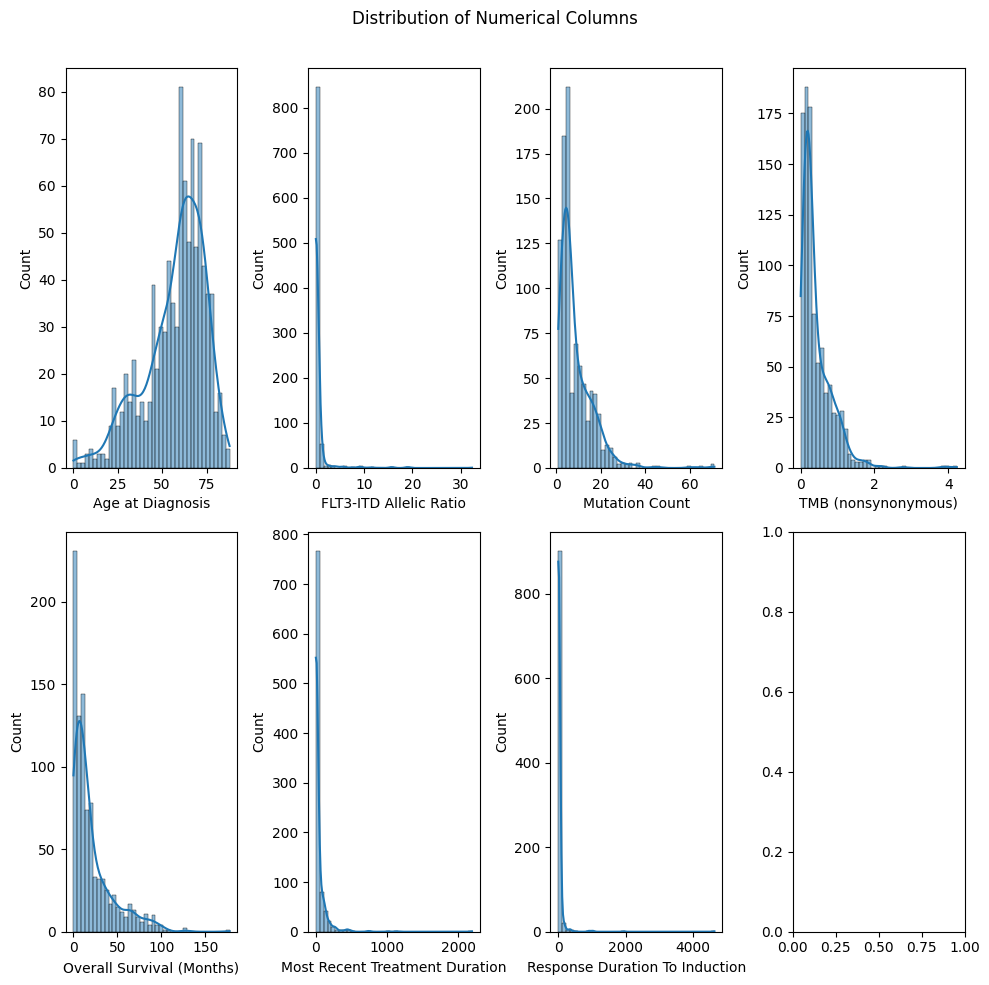

In [130]:
fig, axes = plt.subplots(2, 4, figsize = (10,10))
axes = axes.flatten()

for i, cols in enumerate(numeric_cols):
    sns.histplot(x = cols,
                 data = df,
                 ax= axes[i],
                 kde = True,
                 bins=40)

plt.suptitle('Distribution of Numerical Columns')
plt.tight_layout(rect=[0, 0, 1, 0.97])

# tho age is at normal distribution and others are heavily right skewed, all will undergo robust scaler

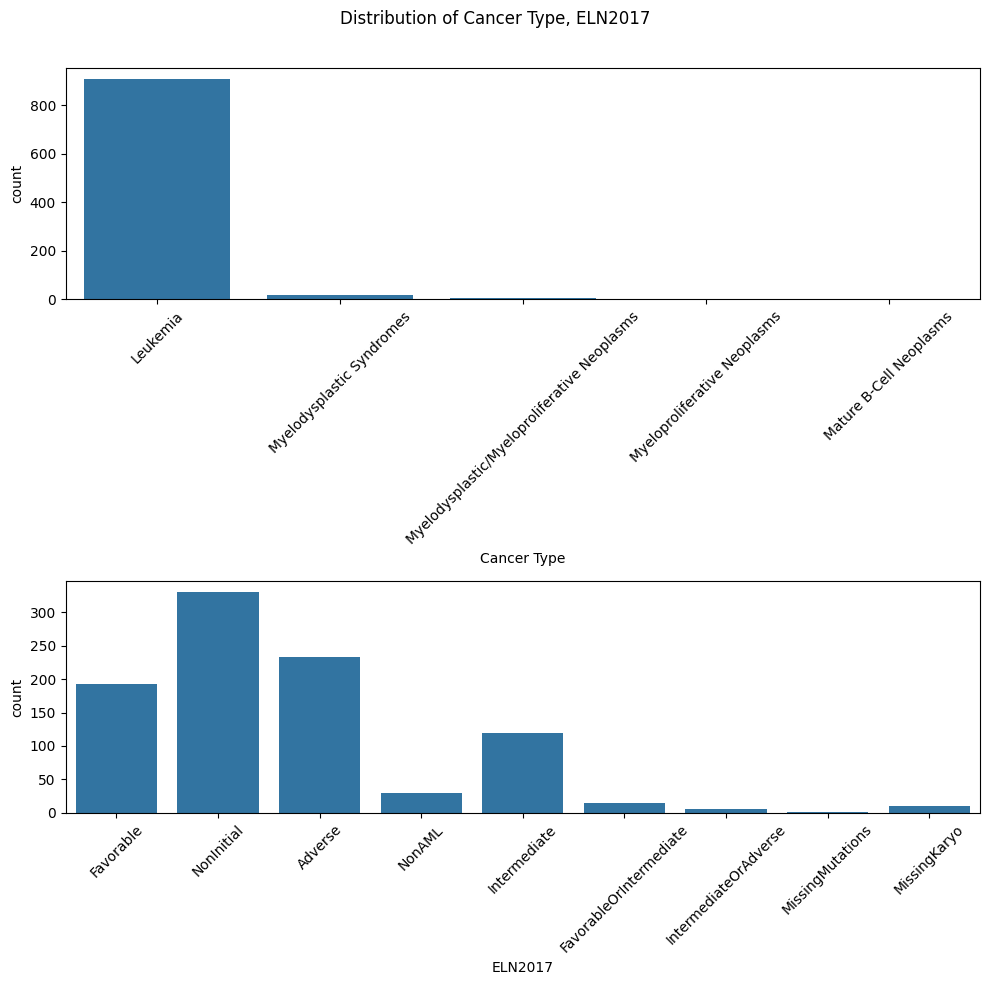

In [131]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

cols_to_plot = ['Cancer Type', 'ELN2017']

for i, cols in enumerate(cols_to_plot):
    sns.countplot(x = cols,
                 data = df,
                 ax= axes[i])
    axes[i].tick_params(axis='x', rotation=45)

plt.suptitle('Distribution of Cancer Type, ELN2017')
plt.tight_layout(rect=[0, 0, 1, 0.97])

# Little representation of the other type of cancer
# wide spectrum of cancer types, might need to consolidate others

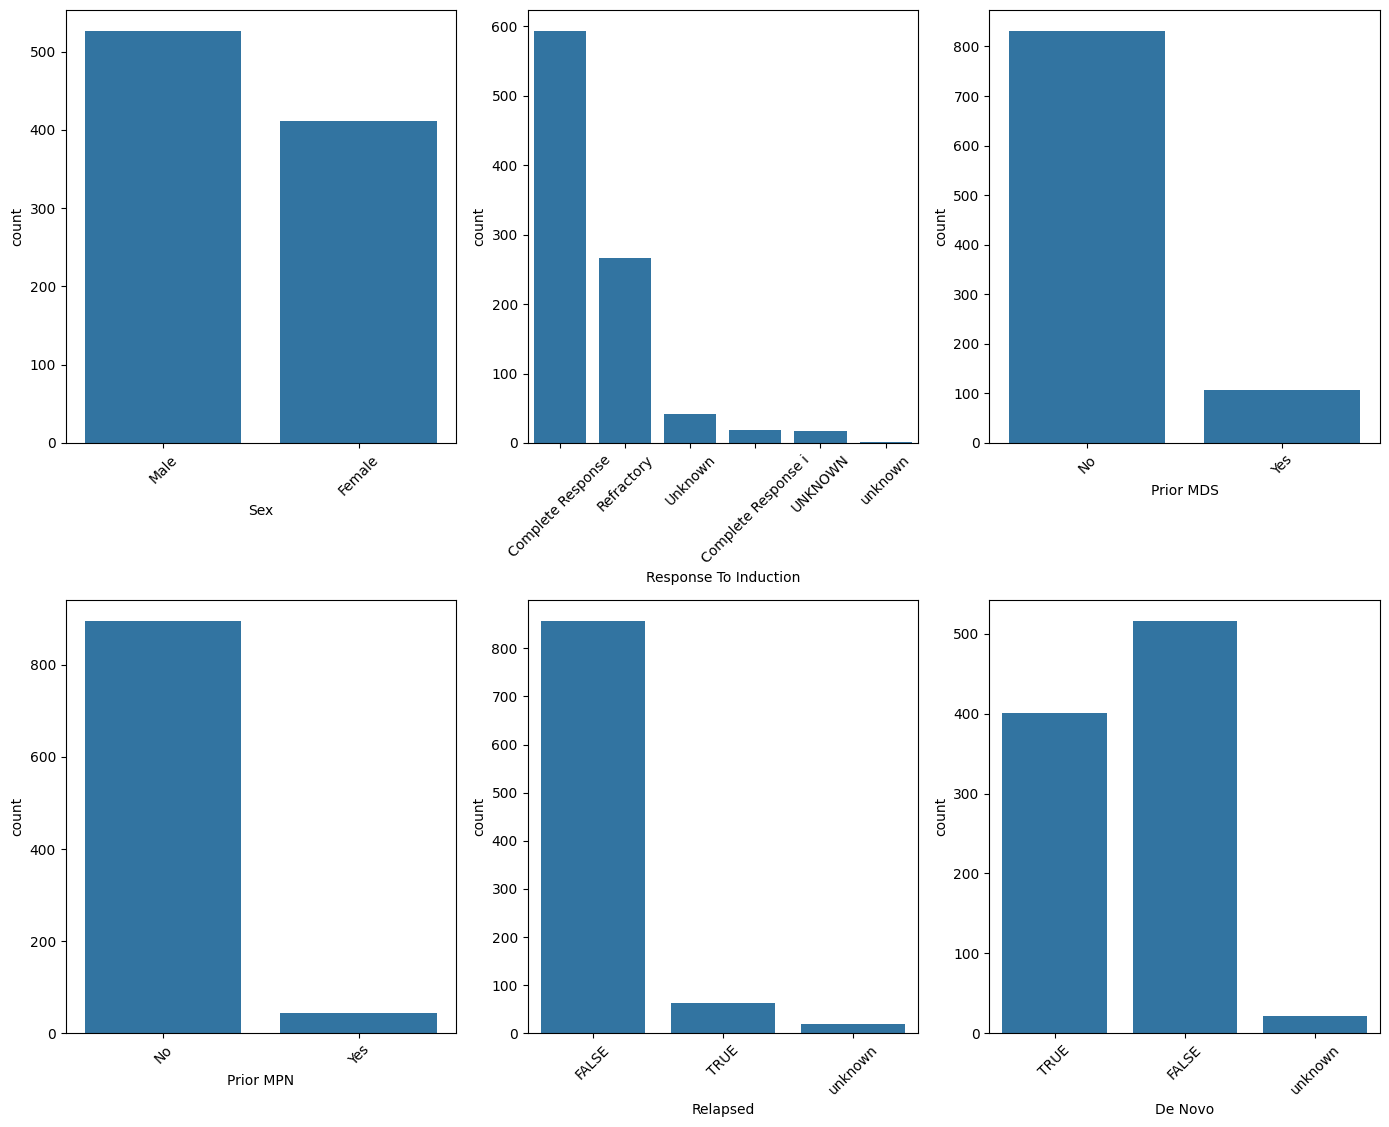

In [132]:
fig, axes = plt.subplots(2, 3, figsize=(14, 12))
axes = axes.flatten()
cols_to_plot = ['Sex', 'Response To Induction', 'Prior MDS', 'Prior MPN', 'Relapsed', 'De Novo']

for i, cols in enumerate(cols_to_plot):
    sns.countplot(x = cols,
                 data = df,
                 ax= axes[i])
    axes[i].tick_params(axis='x', rotation=45)

plt.suptitle('')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# dominant male participants
# so many unknown need to clean 
# Few patients had precursor conditions
# Majority are first-time diagnoses
# Suggests many secondary or therapy-related AMLs, not new-onset


In [133]:
df[cat_cols] = df[cat_cols].apply(lambda x: x.astype(str).str.strip().str.lower())

replace_map = {
    'complete response i': 'complete response',
    'unk': 'unknown',
    'unknown': 'unknown',
    'favorableorintermediate': 'favorable/intermediate',
    'intermediateoradverse': 'intermediate/adverse',
    'missingkaryo': 'missing',
    'missingmutations': 'missing',
    'noninitial': 'non-initial'
}

df = df.replace(replace_map)

In [134]:
for col in cat_cols:
    print(f"\n{col}:\n", df[col].value_counts())


Cancer Type:
 Cancer Type
leukemia                                        909
myelodysplastic syndromes                        18
myelodysplastic/myeloproliferative neoplasms      7
myeloproliferative neoplasms                      3
mature b-cell neoplasms                           1
Name: count, dtype: int64

ELN2017:
 ELN2017
non-initial               330
adverse                   234
favorable                 193
intermediate              120
nonaml                     29
favorable/intermediate     15
missing                    11
intermediate/adverse        6
Name: count, dtype: int64

Sex:
 Sex
male      527
female    411
Name: count, dtype: int64

Response To Induction:
 Response To Induction
complete response    612
refractory           267
unknown               59
Name: count, dtype: int64

Prior MDS:
 Prior MDS
no     832
yes    106
Name: count, dtype: int64

Prior MPN:
 Prior MPN
no     895
yes     43
Name: count, dtype: int64

Relapsed:
 Relapsed
false      857
true       

In [135]:
cols_to_map = ['Relapsed', 'De Novo', 'Prior MDS', 'Prior MPN', 'ELN2017', 'Response To Induction']

cols_to_map = [c for c in cols_to_map if c in df.columns]

for col in cols_to_map:
    df[col] = (df[col].astype(str)
                      .str.strip()
                      .str.lower()
                      .replace({'true': 1, 'false': 0, 'unknown': np.nan, 'missing': np.nan}))


C:\Users\jaraneses\AppData\Local\Temp\ipykernel_18000\3366911296.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({'true': 1, 'false': 0, 'unknown': np.nan, 'missing': np.nan}))
C:\Users\jaraneses\AppData\Local\Temp\ipykernel_18000\3366911296.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({'true': 1, 'false': 0, 'unknown': np.nan, 'missing': np.nan}))


In [136]:
for col in cat_cols:
    print(f"\n{col}:\n", df[col].value_counts())


Cancer Type:
 Cancer Type
leukemia                                        909
myelodysplastic syndromes                        18
myelodysplastic/myeloproliferative neoplasms      7
myeloproliferative neoplasms                      3
mature b-cell neoplasms                           1
Name: count, dtype: int64

ELN2017:
 ELN2017
non-initial               330
adverse                   234
favorable                 193
intermediate              120
nonaml                     29
favorable/intermediate     15
intermediate/adverse        6
Name: count, dtype: int64

Sex:
 Sex
male      527
female    411
Name: count, dtype: int64

Response To Induction:
 Response To Induction
complete response    612
refractory           267
Name: count, dtype: int64

Prior MDS:
 Prior MDS
no     832
yes    106
Name: count, dtype: int64

Prior MPN:
 Prior MPN
no     895
yes     43
Name: count, dtype: int64

Relapsed:
 Relapsed
0.0    857
1.0     62
Name: count, dtype: int64

De Novo:
 De Novo
0.0    516
1.0

In [137]:
# since majority of the cancer type is leukemia, convert the other categories, others. 

df['Cancer Type'] = df['Cancer Type'].apply(lambda x : 'leukemia' if x == 'leukemia' else 'others')
df['Cancer Type'].value_counts()

Cancer Type
leukemia    909
others       29
Name: count, dtype: int64

In [138]:
eln_map = {
    'favorable/intermediate': 'intermediate',
    'intermediate/adverse': 'intermediate',
    'nonaml': 'other'
}
df['ELN2017'] = df['ELN2017'].replace(eln_map)


In [139]:
df['Response To Induction'] = df['Response To Induction'].map({
    'complete response': 1,
    'refractory': 0})

In [140]:
df['Prior MDS'] = df['Prior MDS'].map({'yes': 1, 'no': 0})
df['Prior MPN'] = df['Prior MPN'].map({'yes': 1, 'no': 0})

In [141]:
cols = ['Relapsed', 'De Novo', 'Response To Induction']

for c in cols:
    if c in df.columns:
        df[c] = (df[c]
                 .replace({'0.0': '0', '1.0': '1'})
                 .replace({'true': '1', 'false': '0'})
                 .astype(str).str.strip())
        
        df[c] = pd.to_numeric(df[c], errors='coerce').astype('Int64')


In [142]:
for col in cat_cols:
    print(f"\n{col}:\n", df[col].value_counts())


Cancer Type:
 Cancer Type
leukemia    909
others       29
Name: count, dtype: int64

ELN2017:
 ELN2017
non-initial     330
adverse         234
favorable       193
intermediate    141
other            29
Name: count, dtype: int64

Sex:
 Sex
male      527
female    411
Name: count, dtype: int64

Response To Induction:
 Response To Induction
1    612
0    267
Name: count, dtype: Int64

Prior MDS:
 Prior MDS
0    832
1    106
Name: count, dtype: int64

Prior MPN:
 Prior MPN
0    895
1     43
Name: count, dtype: int64

Relapsed:
 Relapsed
0    857
1     62
Name: count, dtype: Int64

De Novo:
 De Novo
0    516
1    401
Name: count, dtype: Int64


In [143]:
for col in cat_cols:
    df.loc[:, col] = df[col].fillna(df[col].mode()[0])

df[cat_cols].isnull().sum()

Cancer Type              0
ELN2017                  0
Sex                      0
Response To Induction    0
Prior MDS                0
Prior MPN                0
Relapsed                 0
De Novo                  0
dtype: int64

In [144]:
scaler = RobustScaler()

df_numeric_scaled = pd.DataFrame(scaler.fit_transform(df[numeric_cols]), columns= numeric_cols)
df_encoded_cat = pd.get_dummies(df[cat_cols], drop_first = True)
X = pd.concat([
    df_numeric_scaled.reset_index(drop=True),
    df_encoded_cat.reset_index(drop=True)
], axis=1)


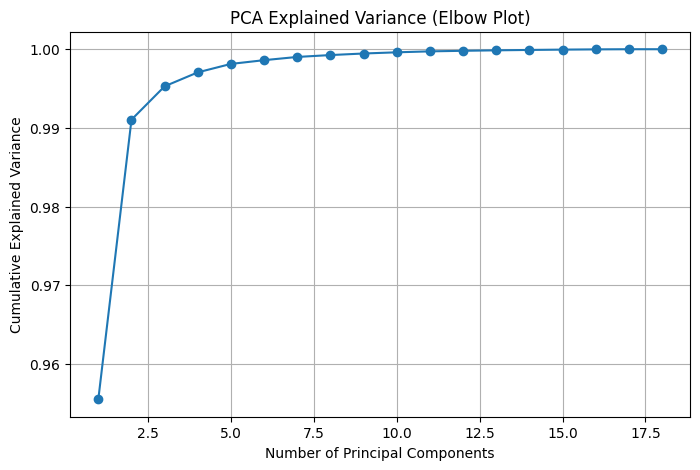

In [145]:
pca = PCA().fit(X)
explained = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained)+1), explained, marker='o')
plt.title("PCA Explained Variance (Elbow Plot)")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

In [ ]:
pca = PCA().fit(X)
explained = np.round(pca.explained_variance_ratio_ * 100, 2)
cum_explained = np.cumsum(explained)

print("Explained variance per PC (%):", explained[:10])
print("Cumulative variance (%):", cum_explained[:10])

# Most of the data variation (95%) can be summarized by the first principal component (PC1), 
# meaning that one underlying factor captures nearly all the structural differences across samples.



Explained variance per PC (%): [9.555e+01 3.550e+00 4.200e-01 1.800e-01 1.100e-01 5.000e-02 4.000e-02
 2.000e-02 2.000e-02 2.000e-02]
Cumulative variance (%): [95.55 99.1  99.52 99.7  99.81 99.86 99.9  99.92 99.94 99.96]


In [155]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2', 'PC3'],
    index=X.columns
)

for pc in ['PC1', 'PC2', 'PC3']:
    print(f"\nTop contributors to {pc}:")
    print(loadings[pc].abs().sort_values(ascending=False).head(10))


Top contributors to PC1:
Response Duration To Induction    0.999972
Overall Survival (Months)         0.006870
Prior MPN                         0.001220
Cancer Type_others                0.001184
ELN2017_other                     0.001184
Age at Diagnosis                  0.001155
FLT3-ITD Allelic Ratio            0.001109
Sex_male                          0.000698
De Novo                           0.000687
Most Recent Treatment Duration    0.000629
Name: PC1, dtype: float64

Top contributors to PC2:
Most Recent Treatment Duration    0.999207
FLT3-ITD Allelic Ratio            0.035012
Overall Survival (Months)         0.017632
ELN2017_favorable                 0.003381
Mutation Count                    0.002984
Age at Diagnosis                  0.002649
Sex_male                          0.002522
ELN2017_non-initial               0.002455
TMB (nonsynonymous)               0.001934
De Novo                           0.001430
Name: PC2, dtype: float64

Top contributors to PC3:
FLT3-ITD A

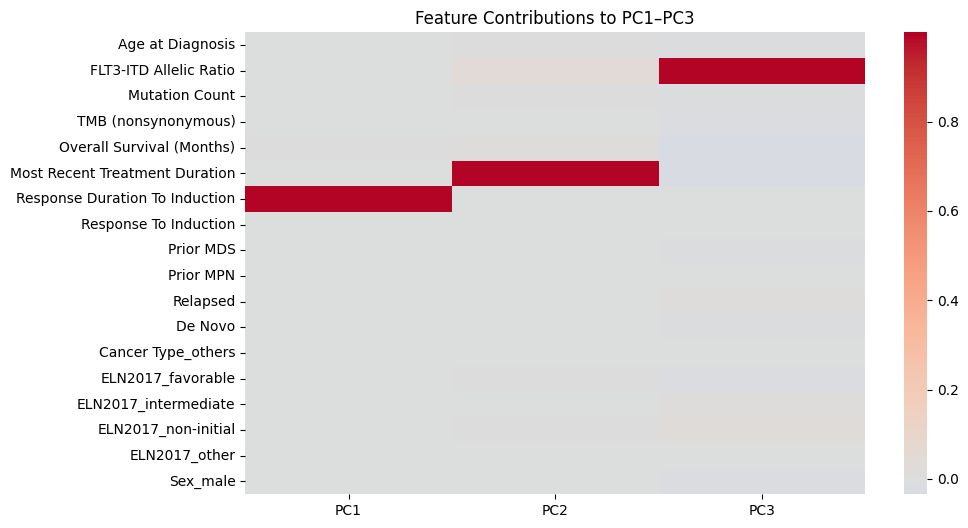

In [154]:
plt.figure(figsize=(10,6))
sns.heatmap(loadings, cmap='coolwarm', center=0)
plt.title("Feature Contributions to PC1–PC3")
plt.show()


In [150]:
sil_scores = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)
    sil = silhouette_score(X_pca, labels)
    sil_scores.append(sil)
    print(f"k={k}, silhouette={sil:.3f}")

k=2, silhouette=0.987
k=3, silhouette=0.962
k=4, silhouette=0.856
k=5, silhouette=0.848
k=6, silhouette=0.865
k=7, silhouette=0.805


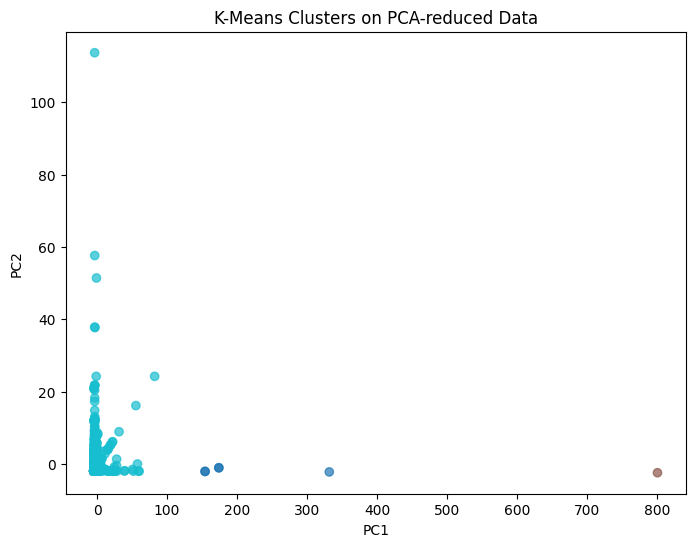

In [151]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_pca)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='tab10', alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-Means Clusters on PCA-reduced Data")
plt.show()

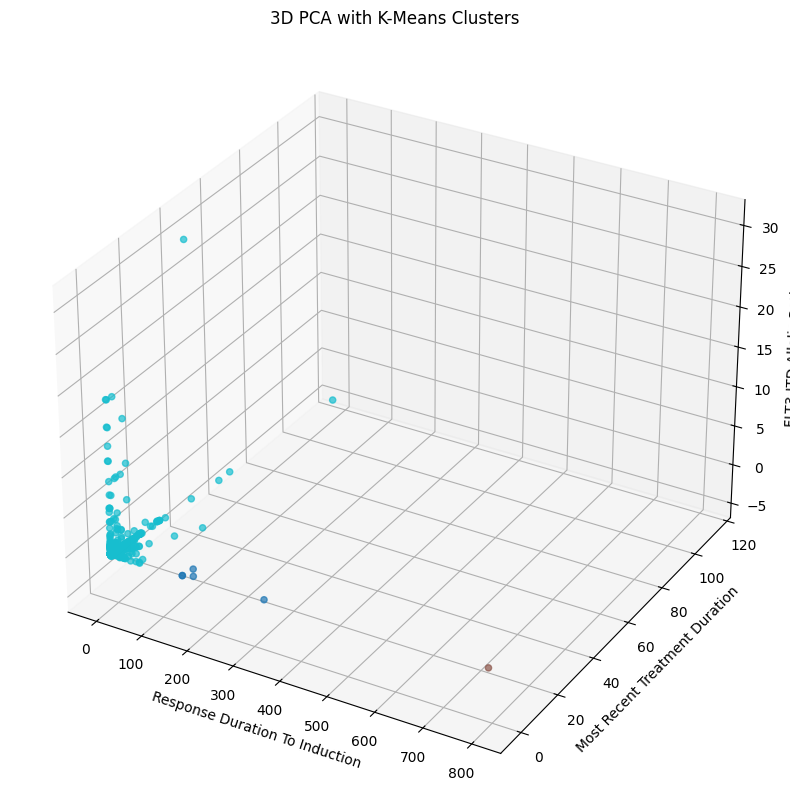

In [157]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=labels, cmap='tab10', alpha=0.7)
ax.set_xlabel("Response Duration To Induction")
ax.set_ylabel("Most Recent Treatment Duration")
ax.set_zlabel("FLT3-ITD Allelic Ratio")
plt.title("3D PCA with K-Means Clusters")
plt.show()


In [158]:
df['Cluster'] = labels

df.groupby('Cluster')[['Response Duration To Induction', 
                       'Most Recent Treatment Duration', 
                       'FLT3-ITD Allelic Ratio', 
                       'Overall Survival (Months)']].median()


,Response Duration To Induction,Most Recent Treatment Duration,FLT3-ITD Allelic Ratio,Overall Survival (Months)
Cluster,,,,
0,1025.0,-1.0,0.0,41.556164
1,4626.0,-1.0,0.0,177.435616
2,6.0,0.0,0.0,11.835616


Using PCA and K-Means, three patient groups were identified based mainly on how well they responded to treatment and how long they survived. The first group includes long-term responders who showed outstanding recovery and survival outcomes. The second group represents moderate responders with average treatment results, while the third group consists of poor responders who had short treatment responses and lower survival rates. Interestingly, genetic factors like the FLT3-ITD mutation did not seem to affect these groupings, meaning the clusters were mostly shaped by differences in clinical treatment response rather than genetic variation.
